# HW2P2: Image Recognition and Verification

This is the second homework  in 11785: Introduction to Deep Learning. We are trying to tackle the problem of Image Verification. For this, we will need to first train our own CNN model to tackle the problem of classification, consisting of 8631 identities. Using this, we get the face embeddings for different pairs of images and try to identify if the pair of face matches or not.

# Libraries

In [1]:
!nvidia-smi # Run this to see what GPU you have

Thu Feb 27 21:35:30 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   39C    P8             11W /   70W |       1MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
!pip install wandb --quiet # Install WandB
!pip install pytorch_metric_learning --quiet #Install the Pytorch Metric Library

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.9/125.9 kB 4.0 MB/s eta 0:00:00


TODO: Change Imports based on new dataset

In [3]:
import torch
from torchsummary import summary
import torchvision
from torchvision.utils import make_grid
from torchvision import transforms
import torchvision.transforms.v2 as T
from torch.utils.data import DataLoader
import torch.nn.functional as F
import os
import gc
from tqdm import tqdm
from PIL import Image
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn import metrics as mt
from scipy.optimize import brentq
from scipy.interpolate import interp1d
import glob
import wandb
import matplotlib.pyplot as plt
from pytorch_metric_learning import samplers
import csv

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device: ", DEVICE)


Device:  cuda


In [4]:
# from google.colab import drive # Link to your drive if you are not using Colab with GCP
# drive.mount('/content/drive') # Models in this HW take a long time to get trained and make sure to save it here

# Kaggle

# Config

In [5]:
config = {
    'batch_size': 128, # Increase this if your GPU can handle it
    'lr': 0.1,
    'epochs': 55, # 20 epochs is recommended ONLY for the early submission - you will have to train for much longer typically.
    'num_classes': 8631, #Dataset contains 8631 classes for classification, reduce this number if you want to train on a subset, but only for train dataset and not on val dataset
    'cls_data_dir': "/kaggle/input/11785-hw-2-p-2-face-verification-spring-2025/HW2p2_S25/cls_data/", #TODO: Provide path of classification directory
    'ver_data_dir': "/kaggle/input/11785-hw-2-p-2-face-verification-spring-2025/HW2p2_S25/ver_data", #TODO: Provide path of verification directory
    'val_pairs_file': "/kaggle/input/11785-hw-2-p-2-face-verification-spring-2025/HW2p2_S25/val_pairs.txt", #TODO: Provide path of text file containing val pairs for verification
    'test_pairs_file': "/kaggle/input/11785-hw-2-p-2-face-verification-spring-2025/HW2p2_S25/test_pairs.txt", #TODO: Provide path of text file containing test pairs for verification
    'checkpoint_dir': "/kaggle/working/model_checkpoints", #TODO: Checkpoint directory
    'augument': True
    # Include other parameters as needed.
}

# Dataset

In [6]:
def create_transforms(image_size: int = 112, augment: bool = True) -> T.Compose:
    """Create transform pipeline for face recognition."""

    # Step 1: Basic transformations
    transform_list = [
        # Resize the image to the desired size (image_size x image_size)
        T.Resize((image_size, image_size)),

        # Convert PIL Image to tensor
        T.ToTensor(),

        # Convert image to float32 and scale the pixel values to [0, 1]
        T.ToDtype(torch.float32, scale=True),
    ]

    # Step 2: Data augmentation (optional, based on `augment` argument)
    if augment:  # This block will be executed if `augment=True`
        # TODO: Add transformations for data augmentation (e.g., random horizontal flip, rotation, etc.)
        # Example:
        transform_list.extend([
            T.RandomHorizontalFlip(p=0.5),  
            T.RandomRotation(degrees=10),
        ])

    # Step 3: Standard normalization for image recognition tasks
    # The Normalize transformation requires mean and std values for each channel (R, G, B).
    # Here, we are normalizing the pixel values to have a mean of 0.5 and std of 0.5 for each channel.
    transform_list.extend([
        T.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # Standard mean and std for face recognition tasks
    ])

    # Return the composed transformation pipeline
    return T.Compose(transform_list)


## Classification Datasets and Dataloaders

In [7]:
class ImageDataset(torch.utils.data.Dataset):
    """Custom dataset for loading image-label pairs."""
    def __init__(self, root, transform, num_classes=config['num_classes']):
        """
        Args:
            root (str): Path to the directory containing the images folder.
            transform (callable): Transform to be applied to the images.
            num_classes (int, optional): Number of classes to keep. If None, keep all classes.
        """
        self.root = root
        self.labels_file = os.path.join(self.root, "labels.txt")
        self.transform = transform
        self.image_paths = []
        self.labels = []
        self.classes = set()

        # Read image-label pairs from the file
        with open(self.labels_file, 'r') as f:
            lines = f.readlines()

        lines = sorted(lines, key=lambda x: int(x.strip().split(' ')[-1]))

        # Get all unique labels first
        all_labels = sorted(set(int(line.strip().split(' ')[1]) for line in lines))

         # Select subset of classes if specified
        if num_classes is not None:
            selected_classes = set(all_labels[:num_classes])
        else:
            selected_classes = set(all_labels)

        # Store image paths and labels with a progress bar
        for line in tqdm(lines, desc="Loading dataset"):
            img_path, label = line.strip().split(' ')
            label = int(label)

            # Only add if label is in selected classes
            if label in selected_classes:
                self.image_paths.append(os.path.join(self.root, 'images', img_path))
                self.labels.append(label)
                self.classes.add(label)

        assert len(self.image_paths) == len(self.labels), "Images and labels mismatch!"

        # Convert classes to a sorted list
        self.classes = sorted(self.classes)

    def __len__(self):
        """Returns the total number of samples."""
        return len(self.image_paths)

    def __getitem__(self, idx):
        """
        Args:
            idx (int): Index of the sample to retrieve.

        Returns:
            tuple: (transformed image, label)
        """
        # Load and transform image on-the-fly
        image = Image.open(self.image_paths[idx]).convert('RGB')
        image = self.transform(image)
        label = self.labels[idx]
        return image, label

gc.collect()

30

In [8]:
# train transforms
train_transforms = create_transforms(augment=config['augument'])

# val transforms
val_transforms   = create_transforms(augment=False)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [9]:
# Datasets
cls_train_dataset = ImageDataset(root=os.path.join(config["cls_data_dir"], "train"),transform=train_transforms)
cls_val_dataset   =ImageDataset(root=os.path.join(config["cls_data_dir"], "dev"),transform=val_transforms )
cls_test_dataset  = ImageDataset(root=os.path.join(config["cls_data_dir"], "test"),transform=val_transforms )

assert cls_train_dataset.classes == cls_val_dataset.classes == cls_test_dataset.classes, "Class mismatch!"


# Dataloaders
cls_train_loader = DataLoader(cls_train_dataset, batch_size=config['batch_size'], shuffle=True,  num_workers=4, pin_memory=True)
cls_val_loader   = DataLoader(cls_val_dataset,   batch_size=config['batch_size'], shuffle=False, num_workers=4, pin_memory=True)
cls_test_loader  = DataLoader(cls_test_dataset,  batch_size=config['batch_size'], shuffle=False, num_workers=4, pin_memory=True)

Loading dataset: 100%|██████████| 43155/43155 [00:00<00:00, 329941.39it/s]


## Verification Dataset and Datatloaders

In [10]:
class ImagePairDataset(torch.utils.data.Dataset):
    """Custom dataset for loading and transforming image pairs."""
    def __init__(self, root, pairs_file, transform):
        """
        Args:
            root (str): Path to the directory containing the images.
            pairs_file (str): Path to the file containing image pairs and match labels.
            transform (callable): Transform to be applied to the images.
        """
        self.root      = root
        self.transform = transform

        self.matches     = []
        self.image1_list = []
        self.image2_list = []

        # Read and load image pairs and match labels
        with open(pairs_file, 'r') as f:
            lines = f.readlines()

        for line in tqdm(lines, desc="Loading image pairs"):
            img_path1, img_path2, match = line.strip().split(' ')
            img1 = Image.open(os.path.join(self.root, img_path1)).convert('RGB')
            img2 = Image.open(os.path.join(self.root, img_path2)).convert('RGB')

            self.image1_list.append(img1)
            self.image2_list.append(img2)
            self.matches.append(int(match))  # Convert match to integer

        assert len(self.image1_list) == len(self.image2_list) == len(self.matches), "Image pair mismatch"

    def __len__(self):
        """Returns the total number of samples."""
        return len(self.image1_list)

    def __getitem__(self, idx):
        """
        Args:
            idx (int): Index of the sample to retrieve.

        Returns:
            tuple: (transformed image1, transformed image2, match label)
        """
        img1 = self.image1_list[idx]
        img2 = self.image2_list[idx]
        match = self.matches[idx]
        return self.transform(img1), self.transform(img2), match


In [11]:
class TestImagePairDataset(torch.utils.data.Dataset):
    """Custom dataset for loading and transforming image pairs."""
    def __init__(self, root, pairs_file, transform):
        """
        Args:
            root (str): Path to the directory containing the images.
            pairs_file (str): Path to the file containing image pairs and match labels.
            transform (callable): Transform to be applied to the images.
        """
        self.root      = root
        self.transform = transform

        self.image1_list = []
        self.image2_list = []

        # Read and load image pairs and match labels
        with open(pairs_file, 'r') as f:
            lines = f.readlines()

        for line in tqdm(lines, desc="Loading image pairs"):
            img_path1, img_path2 = line.strip().split(' ')
            img1 = Image.open(os.path.join(self.root, img_path1)).convert('RGB')
            img2 = Image.open(os.path.join(self.root, img_path2)).convert('RGB')

            self.image1_list.append(img1)
            self.image2_list.append(img2)

        assert len(self.image1_list) == len(self.image2_list), "Image pair mismatch"

    def __len__(self):
        """Returns the total number of samples."""
        return len(self.image1_list)

    def __getitem__(self, idx):
        """
        Args:
            idx (int): Index of the sample to retrieve.

        Returns:
            tuple: (transformed image1, transformed image2, match label)
        """
        img1 = self.image1_list[idx]
        img2 = self.image2_list[idx]
        return self.transform(img1), self.transform(img2)


In [12]:
# Datasets
ver_val_dataset  =ImagePairDataset(root=config["ver_data_dir"], pairs_file=config["val_pairs_file"], transform=val_transforms) #TODO
ver_test_dataset =TestImagePairDataset(root=config["ver_data_dir"],pairs_file=config["test_pairs_file"], transform=val_transforms) #TODO

# Dataloader
ver_val_loader   = DataLoader(ver_val_dataset,  batch_size=config['batch_size'], shuffle=False, num_workers=8, pin_memory=True)
ver_test_loader  = DataLoader(ver_test_dataset, batch_size=config['batch_size'], shuffle=False, num_workers=8, pin_memory=True)


Loading image pairs: 100%|██████████| 6000/6000 [00:41<00:00, 145.34it/s]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


## Create Dataloaders for Image Recognition

# EDA and Viz

In [13]:
# Double-check your dataset/dataloaders work as expected

print("Number of classes    : ", len(cls_train_dataset.classes))
print("No. of train images  : ", cls_train_dataset.__len__())
print("Shape of image       : ", cls_train_dataset[0][0].shape)
print("Batch size           : ", config['batch_size'])
print("Train batches        : ", cls_train_loader.__len__())
print("Val batches          : ", cls_val_loader.__len__())

# Feel free to print more things if needed

Number of classes    :  8631
No. of train images  :  431550
Shape of image       :  torch.Size([3, 112, 112])
Batch size           :  128
Train batches        :  3372
Val batches          :  338


### Classification Dataset Viz

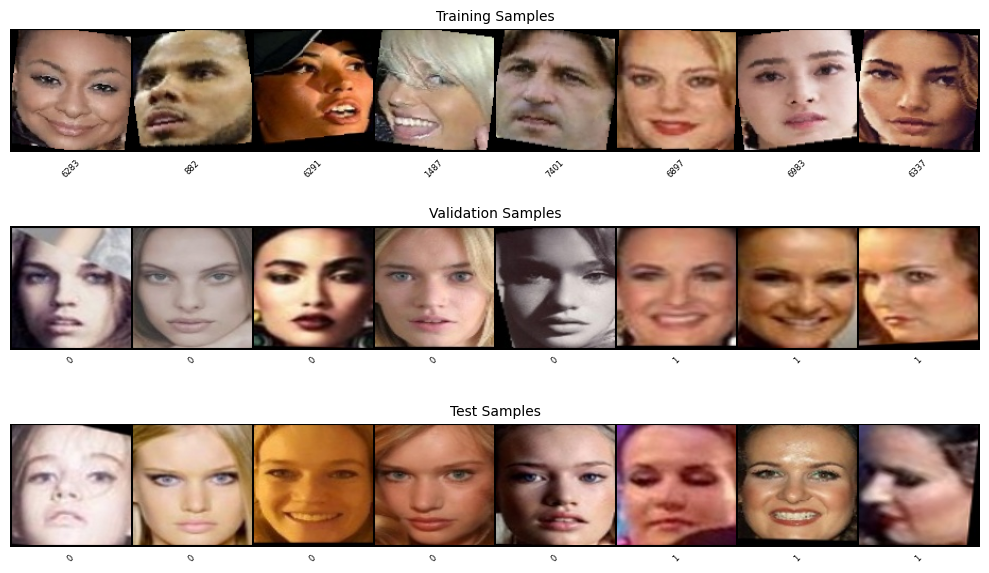

In [14]:
def show_cls_dataset_samples(train_loader, val_loader, test_loader, samples_per_set=8, figsize=(10, 6)):
    """
    Display samples from train, validation, and test datasets side by side

    Args:
        train_loader: Training data loader
        val_loader: Validation data loader
        test_loader: Test data loader
        samples_per_set: Number of samples to show from each dataset
        figsize: Figure size (width, height)
    """
    def denormalize(x):
        """Denormalize images from [-1, 1] to [0, 1]"""
        return x * 0.5 + 0.5

    def get_samples(loader, n):
        """Get n samples from a dataloader"""
        batch = next(iter(loader))
        return batch[0][:n], batch[1][:n]

    # Get samples from each dataset
    train_imgs, train_labels = get_samples(train_loader, samples_per_set)
    val_imgs, val_labels = get_samples(val_loader, samples_per_set)
    test_imgs, test_labels = get_samples(test_loader, samples_per_set)

    # Create figure
    fig, axes = plt.subplots(3, 1, figsize=figsize)

    # Plot each dataset
    for idx, (imgs, labels, title) in enumerate([
        (train_imgs, train_labels, 'Training Samples'),
        (val_imgs, val_labels, 'Validation Samples'),
        (test_imgs, test_labels, 'Test Samples')
    ]):

        # Create grid of images
        grid = make_grid(denormalize(imgs), nrow=8, padding=2)

        # Display grid
        axes[idx].imshow(grid.permute(1, 2, 0).cpu())
        axes[idx].axis('off')
        axes[idx].set_title(title, fontsize=10)

        # Add class labels below images (with smaller font)
        grid_width = grid.shape[2]
        imgs_per_row = min(8, samples_per_set)
        img_width = grid_width // imgs_per_row

        for i, label in enumerate(labels):
            col = i % imgs_per_row  # Calculate column position
            if label<len(train_loader.dataset.classes):
              class_name = train_loader.dataset.classes[label]
            else:
              class_name = f"Class {label} (Unknown)"
            axes[idx].text(col * img_width + img_width/2,
                         grid.shape[1] + 5,
                         class_name,
                         ha='center',
                         va='top',
                         fontsize=6,
                         rotation=45)

    plt.tight_layout()
    plt.show()

show_cls_dataset_samples(cls_train_loader, cls_val_loader, cls_test_loader)

### Ver Dataset Viz

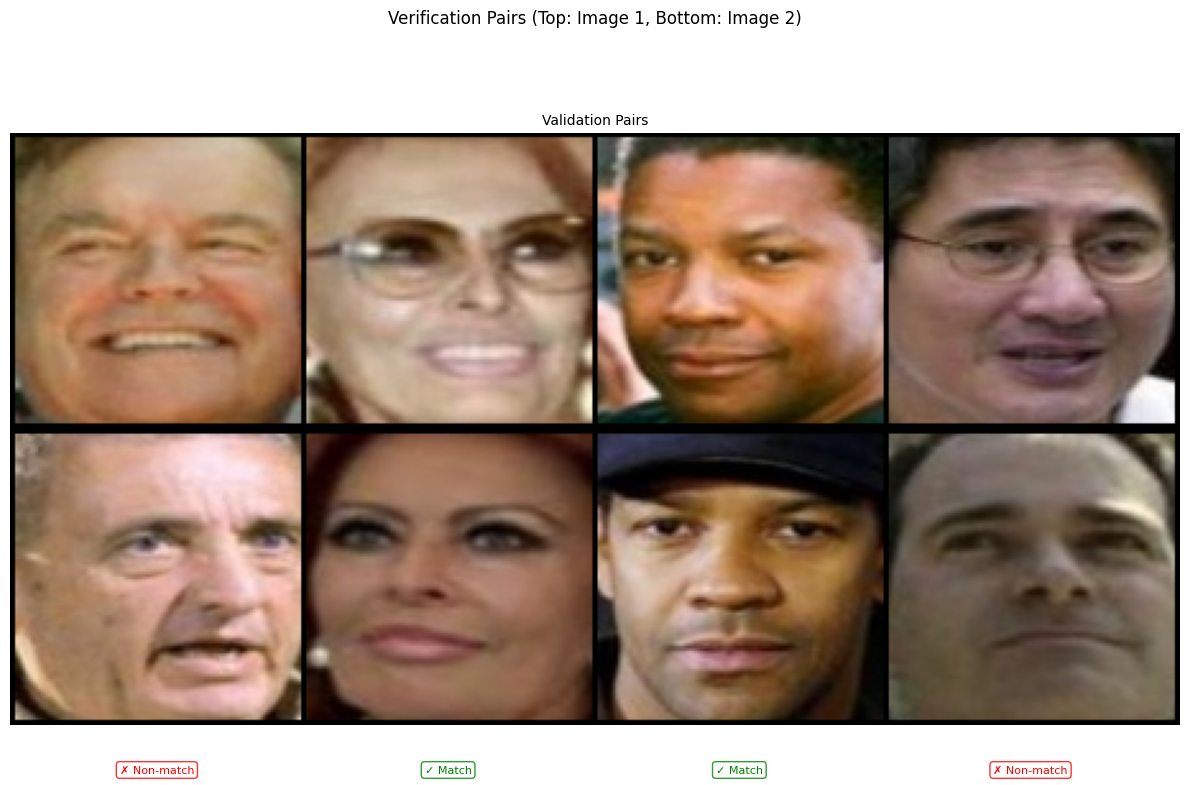

In [15]:
import matplotlib.pyplot as plt
import torch
from torchvision.utils import make_grid

def show_ver_dataset_samples(val_loader, samples_per_set=4, figsize=(12, 8)):
    """
    Display verification pairs from the validation dataset

    Args:
        val_loader: Validation data loader
        samples_per_set: Number of pairs to show from the dataset
        figsize: Figure size (width, height)
    """
    def denormalize(x):
        """Denormalize images from [-1, 1] to [0, 1]"""
        return x * 0.5 + 0.5

    def get_samples(loader, n):
        """Get n samples from a dataloader"""
        batch = next(iter(loader))
        return batch[0][:n], batch[1][:n], batch[2][:n]

    # Get samples from the validation dataset
    val_imgs1, val_imgs2, val_labels = get_samples(val_loader, samples_per_set)

    # Create figure and axis
    fig, ax = plt.subplots(1, 1, figsize=figsize)

    # Create grids for both images in each pair
    grid1 = make_grid(denormalize(val_imgs1), nrow=samples_per_set, padding=2)
    grid2 = make_grid(denormalize(val_imgs2), nrow=samples_per_set, padding=2)

    # Combine the grids vertically
    combined_grid = torch.cat([grid1, grid2], dim=1)

    # Display the combined grid
    ax.imshow(combined_grid.permute(1, 2, 0).cpu())
    ax.axis('off')
    ax.set_title('Validation Pairs', fontsize=10)

    # Determine dimensions for placing the labels
    grid_width = grid1.shape[2]
    img_width = grid_width // samples_per_set

    # Add match/non-match labels for each pair
    for i, label in enumerate(val_labels):
        match_text = "✓ Match" if label == 1 else "✗ Non-match"
        color = 'green' if label == 1 else 'red'

        # Define a background box for the label
        bbox_props = dict(
            boxstyle="round,pad=0.3",
            fc="white",
            ec=color,
            alpha=0.8
        )

        ax.text(i * img_width + img_width / 2,
                combined_grid.shape[1] + 15,  # Position below the images
                match_text,
                ha='center',
                va='top',
                fontsize=8,
                color=color,
                bbox=bbox_props)

    plt.suptitle("Verification Pairs (Top: Image 1, Bottom: Image 2)", y=1.02)
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.05)
    plt.show()

show_ver_dataset_samples(ver_val_loader)


# Model Architecture

FAQ:

**What's a very low early deadline architecture (mandatory early submission)**?

- The very low early deadline architecture is a 5-layer CNN. Keep in mind the parameter limit for this homework is 30M.
- The first convolutional layer has 64 channels, kernel size 7, and stride 4. The next three have 128, 256, 512 and 1024 channels. Each have kernel size 3 and stride 2. Documentation to make convolutional layers: https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html
- Think about strided convolutions from the lecture, as convolutions with stride = 1 and downsampling. For strided convolution, what padding do you need for preserving the spatial resolution? (Hint => padding = kernel_size // 2) - Think why?
- Each convolutional layer is accompanied by a Batchnorm and ReLU layer.
- Finally, you want to average pool over the spatial dimensions to reduce them to 1 x 1. Use AdaptiveAvgPool2d. Documentation for AdaptiveAvgPool2d: https://pytorch.org/docs/stable/generated/torch.nn.AdaptiveAvgPool2d.html
- Then, remove (Flatten?) these trivial 1x1 dimensions away.
Look through https://pytorch.org/docs/stable/nn.html


**Why does a very simple network have 4 convolutions**?

Input images are 112x112. Note that each of these convolutions downsample. Downsampling 2x effectively doubles the receptive field, increasing the spatial region each pixel extracts features from. Downsampling 32x is standard for most image models.

**Why does a very simple network have high channel sizes**?

Every time you downsample 2x, you do 4x less computation (at same channel size). To maintain the same level of computation, you 2x increase # of channels, which increases computation by 4x. So, balances out to same computation. Another intuition is - as you downsample, you lose spatial information. We want to preserve some of it in the channel dimension.

**What is return_feats?**

It essentially returns the second-to-last-layer features of a given image. It's a "feature encoding" of the input image, and you can use it for the verification task. You would use the outputs of the final classification layer for the classification task. You might also find that the classification outputs are sometimes better for verification too - try both.

In [16]:
class ResidualBlock(torch.nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = torch.nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = torch.nn.BatchNorm2d(out_channels)
        self.relu = torch.nn.ReLU()
        self.conv2 = torch.nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = torch.nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        if self.downsample is not None:
            identity = self.downsample(x)
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += identity
        out = self.relu(out)
        return out

class Network(torch.nn.Module):
    def __init__(self, num_classes):
        super(Network, self).__init__()
        self.conv1 = torch.nn.Conv2d(3, 128, kernel_size=7, stride=4, padding=3, bias=False)
        self.bn1 = torch.nn.BatchNorm2d(128)
        self.relu = torch.nn.ReLU()
        
        self.layer1 = self._make_layer(128, 256, stride=2)
        self.layer2 = self._make_layer(256, 350, stride=2)
        self.layer3 = self._make_layer(350, 512, stride=2)
        self.layer4 = self._make_layer(512, 512, stride=2)
        
        self.avgpool = torch.nn.AdaptiveAvgPool2d(1)
        self.flatten = torch.nn.Flatten()
        self.cls_layer = torch.nn.Linear(512, num_classes)
    
    def _make_layer(self, in_channels, out_channels, stride):
        downsample = None
        if stride != 1 or in_channels != out_channels:
            downsample = torch.nn.Sequential(
                torch.nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                torch.nn.BatchNorm2d(out_channels),
            )
        return torch.nn.Sequential(
            ResidualBlock(in_channels, out_channels, stride, downsample),
            ResidualBlock(out_channels, out_channels)
        )
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        feats = self.flatten(x)
        out = self.cls_layer(feats)
        
        return {"feats": feats, "out": out}

# Example configuration
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Initialize model
model = Network(num_classes=config['num_classes']).to(DEVICE)
summary(model, (3, 112, 112))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 28, 28]          18,816
       BatchNorm2d-2          [-1, 128, 28, 28]             256
              ReLU-3          [-1, 128, 28, 28]               0
            Conv2d-4          [-1, 256, 14, 14]          32,768
       BatchNorm2d-5          [-1, 256, 14, 14]             512
            Conv2d-6          [-1, 256, 14, 14]         294,912
       BatchNorm2d-7          [-1, 256, 14, 14]             512
              ReLU-8          [-1, 256, 14, 14]               0
            Conv2d-9          [-1, 256, 14, 14]         589,824
      BatchNorm2d-10          [-1, 256, 14, 14]             512
             ReLU-11          [-1, 256, 14, 14]               0
    ResidualBlock-12          [-1, 256, 14, 14]               0
           Conv2d-13          [-1, 256, 14, 14]         589,824
      BatchNorm2d-14          [-1, 256,

In [17]:
# --------------------------------------------------- #

# Defining Loss function
criterion = torch.nn.CrossEntropyLoss() # TODO: What loss do you need for a multi class classification problem and would label smoothing be beneficial here?

# --------------------------------------------------- #

# Defining Optimizer
optimizer =torch.optim.SGD(model.parameters(), lr=config['lr'], momentum=0.9, weight_decay=5e-4)
#torch.optim.AdamW(model.parameters(), lr=config['lr'])  # TODO: Feel free to pick a optimizer

# --------------------------------------------------- #

# Defining Scheduler
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=config['epochs'])
#torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max',patience=3, factor=0.1, threshold=0.1)
# 
# 
# TODO: Use a good scheduler such as ReduceLRonPlateau, StepLR, MultistepLR, CosineAnnealing, etc.

# --------------------------------------------------- #

# Initialising mixed-precision training. # Good news. We've already implemented FP16 (Mixed precision training) for you
# It is useful only in the case of compatible GPUs such as T4/V100
scaler = torch.cuda.amp.GradScaler()

<ipython-input-17-958cdab9ec49>:25: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


# Metrics

In [18]:
class AverageMeter:
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [19]:
def accuracy(output, target, topk=(1,)):
    """Computes the accuracy over the k top predictions for the specified values of k"""
    maxk = min(max(topk), output.size()[1])
    batch_size = target.size(0)
    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.reshape(1, -1).expand_as(pred))
    return [correct[:min(k, maxk)].reshape(-1).float().sum(0) * 100. / batch_size for k in topk]

In [20]:
def get_ver_metrics(labels, scores, FPRs):
    # eer and auc
    fpr, tpr, _ = mt.roc_curve(labels, scores, pos_label=1)
    roc_curve = interp1d(fpr, tpr)
    EER = 100. * brentq(lambda x : 1. - x - roc_curve(x), 0., 1.)
    AUC = 100. * mt.auc(fpr, tpr)

    # get acc
    tnr = 1. - fpr
    pos_num = labels.count(1)
    neg_num = labels.count(0)
    ACC = 100. * max(tpr * pos_num + tnr * neg_num) / len(labels)

    # TPR @ FPR
    if isinstance(FPRs, list):
        TPRs = [
            ('TPR@FPR={}'.format(FPR), 100. * roc_curve(float(FPR)))
            for FPR in FPRs
        ]
    else:
        TPRs = []

    return {
        'ACC': ACC,
        'EER': EER,
        'AUC': AUC,
        'TPRs': TPRs,
    }

# Train and Validation Function

In [21]:
def train_epoch(model, dataloader, optimizer, lr_scheduler, scaler, device, config):

    model.train()

    # metric meters
    loss_m = AverageMeter()
    acc_m = AverageMeter()

    # Progress Bar
    batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, leave=False, position=0, desc='Train', ncols=5)

    for i, (images, labels) in enumerate(dataloader):

        optimizer.zero_grad() # Zero gradients

        # send to cuda
        images = images.to(device, non_blocking=True)
        if isinstance(labels, (tuple, list)):
            targets1, targets2, lam = labels
            labels = (targets1.to(device), targets2.to(device), lam)
        else:
            labels = labels.to(device, non_blocking=True)

        # forward
        with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!
            outputs = model(images)

            # Use the type of output depending on the loss function you want to use
            loss = criterion(outputs['out'], labels)

        scaler.scale(loss).backward() # This is a replacement for loss.backward()
        scaler.step(optimizer) # This is a replacement for optimizer.step()
        scaler.update()
        # metrics
        loss_m.update(loss.item())
        if 'feats' in outputs:
            acc = accuracy(outputs['out'], labels)[0].item()
        else:
            acc = 0.0
        acc_m.update(acc)

        # tqdm lets you add some details so you can monitor training as you train.
        batch_bar.set_postfix(
            # acc         = "{:.04f}%".format(100*accuracy),
            acc="{:.04f}% ({:.04f})".format(acc, acc_m.avg),
            loss        = "{:.04f} ({:.04f})".format(loss.item(), loss_m.avg),
            lr          = "{:.04f}".format(float(optimizer.param_groups[0]['lr'])))

        batch_bar.update() # Update tqdm bar

    # You may want to call some schedulers inside the train function. What are these?
    if lr_scheduler is not None:
        lr_scheduler.step(epoch)

    batch_bar.close()

    return acc_m.avg, loss_m.avg

In [22]:
@torch.no_grad()
def valid_epoch_cls(model, dataloader, device, config):

    model.eval()
    batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, position=0, leave=False, desc='Val Cls.', ncols=5)

    # metric meters
    loss_m = AverageMeter()
    acc_m = AverageMeter()

    for i, (images, labels) in enumerate(dataloader):

        # Move images to device
        images, labels = images.to(device), labels.to(device)

        # Get model outputs
        with torch.inference_mode():
            outputs = model(images)
            loss = criterion(outputs['out'], labels)

        # metrics
        acc = accuracy(outputs['out'], labels)[0].item()
        loss_m.update(loss.item())
        acc_m.update(acc)

        batch_bar.set_postfix(
            acc         = "{:.04f}% ({:.04f})".format(acc, acc_m.avg),
            loss        = "{:.04f} ({:.04f})".format(loss.item(), loss_m.avg))

        batch_bar.update()

    batch_bar.close()
    return acc_m.avg, loss_m.avg

In [23]:
gc.collect() # These commands help you when you face CUDA OOM error
torch.cuda.empty_cache()

# Verification Task

In [24]:
def valid_epoch_ver(model, pair_data_loader, device, config):

    model.eval()
    scores = []
    match_labels = []
    batch_bar = tqdm(total=len(pair_data_loader), dynamic_ncols=True, position=0, leave=False, desc='Val Veri.')
    for i, (images1, images2, labels) in enumerate(pair_data_loader):

        # match_labels = match_labels.to(device)
        images = torch.cat([images1, images2], dim=0).to(device)
        # Get model outputs
        with torch.inference_mode():
            outputs = model(images)

        feats = F.normalize(outputs['feats'], dim=1)
        feats1, feats2 = feats.chunk(2)
        similarity = F.cosine_similarity(feats1, feats2)
        scores.append(similarity.cpu().numpy())
        match_labels.append(labels.cpu().numpy())
        batch_bar.update()

    scores = np.concatenate(scores)
    match_labels = np.concatenate(match_labels)

    FPRs=['1e-4', '5e-4', '1e-3', '5e-3', '5e-2']
    metric_dict = get_ver_metrics(match_labels.tolist(), scores.tolist(), FPRs)
    print(metric_dict)

    return metric_dict['ACC']

# WandB

In [25]:
wandb.login(key="644c2ae8f2e7517b4257e8a4772649248fc7bdce") # API Key is in your wandb account, under settings (wandb.ai/settings)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: yabsera (tseleshi-carnegie-mellon-university). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [26]:
# Create your wandb run
run = wandb.init(
    name = "ResNet3", ## Wandb creates random run names if you skip this field
    reinit = True, ### Allows reinitalizing runs when you re-run this cell
    # run_id = ### Insert specific run id here if you want to resume a previous run
    # resume = "must" ### You need this to resume previous runs, but comment out reinit = True when using this
    project = "hw2p2-ablations", ### Project should be created in your wandb account
    config = config ### Wandb Config for your run
)

wandb: Tracking run with wandb version 0.19.1
wandb: Run data is saved locally in /kaggle/working/wandb/run-20250227_213658-szh8l32s
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run ResNet3
wandb: ⭐️ View project at https://wandb.ai/tseleshi-carnegie-mellon-university/hw2p2-ablations
wandb: 🚀 View run at https://wandb.ai/tseleshi-carnegie-mellon-university/hw2p2-ablations/runs/szh8l32s


# Checkpointing and Loading Model

In [27]:
import os
checkpoint_dir = config['checkpoint_dir']

# Create the directory if it doesn't exist
os.makedirs(checkpoint_dir, exist_ok=True)

In [28]:
def save_model(model, optimizer, scheduler, metrics, epoch, path):
    torch.save(
        {'model_state_dict'         : model.state_dict(),
         'optimizer_state_dict'     : optimizer.state_dict(),
         'scheduler_state_dict'     : scheduler.state_dict(),
         'metric'                   : metrics,
         'epoch'                    : epoch},
         path)


def load_model(model, optimizer=None, scheduler=None, path='./checkpoint.pth'):
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint['model_state_dict'])
    if optimizer is not None:
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    else:
        optimizer = None
    if scheduler is not None:
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    else:
        scheduler = None
    epoch = checkpoint['epoch']
    metrics = checkpoint['metric']
    return model, optimizer, scheduler, epoch, metrics

# Experiments

In [29]:
e = 0
best_valid_cls_acc = 0.0
eval_cls = True
best_valid_ret_acc = 0.0
for epoch in range(e, config['epochs']):
        # epoch
        print("\nEpoch {}/{}".format(epoch+1, config['epochs']))

        # train
        train_cls_acc, train_loss = train_epoch(model, cls_train_loader, optimizer, scheduler, scaler, DEVICE, config)
        curr_lr = float(optimizer.param_groups[0]['lr'])
        print("\nEpoch {}/{}: \nTrain Cls. Acc {:.04f}%\t Train Cls. Loss {:.04f}\t Learning Rate {:.04f}".format(epoch + 1, config['epochs'], train_cls_acc, train_loss, curr_lr))
        metrics = {
            'train_cls_acc': train_cls_acc,
            'train_loss': train_loss,
        }
        # classification validation
        if eval_cls:
            valid_cls_acc, valid_loss = valid_epoch_cls(model, cls_val_loader, DEVICE, config)
            print("Val Cls. Acc {:.04f}%\t Val Cls. Loss {:.04f}".format(valid_cls_acc, valid_loss))
            metrics.update({
                'valid_cls_acc': valid_cls_acc,
                'valid_loss': valid_loss,
            })

        # retrieval validation
        valid_ret_acc = valid_epoch_ver(model, ver_val_loader, DEVICE, config)
        print("Val Ret. Acc {:.04f}%".format(valid_ret_acc))
        metrics.update({
            'valid_ret_acc': valid_ret_acc
        })

        # save model
        save_model(model, optimizer, scheduler, metrics, epoch, os.path.join(config['checkpoint_dir'], 'last.pth'))
        print("Saved epoch model")

        # save best model
        if eval_cls:
            if valid_cls_acc >= best_valid_cls_acc:
                best_valid_cls_acc = valid_cls_acc
                save_model(model, optimizer, scheduler, metrics, epoch, os.path.join(config['checkpoint_dir'], 'best_cls.pth'))
                wandb.save(os.path.join(config['checkpoint_dir'], 'best_cls.pth'))
                print("Saved best classification model")

        if valid_ret_acc >= best_valid_ret_acc:
            best_valid_ret_acc = valid_ret_acc
            save_model(model, optimizer, scheduler, metrics, epoch, os.path.join(config['checkpoint_dir'], 'best_ret.pth'))
            wandb.save(os.path.join(config['checkpoint_dir'], 'best_ret.pth'))
            print("Saved best retrieval model")

        # log to tracker
        if run is not None: 
            run.log(metrics)


Epoch 1/55


Train:   0%|          | 0/3372 [00:00<?, ?it/s]<ipython-input-21-83486346e34c>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!
Train: 100%|█████████▉| 3371/3372 [12:13<00:00,  4.83it/s, acc=0.0000% (0.3547), loss=7.2204 (8.2651), lr=0.1000]/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



Epoch 1/55: 
Train Cls. Acc 0.3547%	 Train Cls. Loss 8.2651	 Learning Rate 0.1000


Val Cls. Acc 1.4076%	 Val Cls. Loss 7.0076


Val Veri.:   0%|          | 0/8 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


{'ACC': 87.0, 'EER': 13.75245579558581, 'AUC': 93.63753856249424, 'TPRs': [('TPR@FPR=1e-4', 27.90224032586558), ('TPR@FPR=5e-4', 27.90224032586558), ('TPR@FPR=1e-3', 27.90224032586558), ('TPR@FPR=5e-3', 36.456211812627295), ('TPR@FPR=5e-2', 69.85743380855396)]}
Val Ret. Acc 87.0000%
Saved epoch model


wandb: WARNING Saving files without folders. If you want to preserve subdirectories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")


Saved best classification model
Saved best retrieval model

Epoch 2/55


Train:   0%|          | 0/3372 [00:00<?, ?it/s]<ipython-input-21-83486346e34c>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!
Train: 100%|█████████▉| 3371/3372 [07:43<00:00,  8.25it/s, acc=3.2258% (4.6623), loss=5.8528 (6.1469), lr=0.1000]/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



Epoch 2/55: 
Train Cls. Acc 4.6623%	 Train Cls. Loss 6.1469	 Learning Rate 0.0999


Val Cls. Acc 7.4912%	 Val Cls. Loss 5.6813


Val Veri.:   0%|          | 0/8 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
                                                        

{'ACC': 91.3, 'EER': 10.019646365289296, 'AUC': 96.63370932182028, 'TPRs': [('TPR@FPR=1e-4', 40.32586558044807), ('TPR@FPR=5e-4', 40.32586558044807), ('TPR@FPR=1e-3', 40.32586558044807), ('TPR@FPR=5e-3', 61.5071283095723), ('TPR@FPR=5e-2', 87.16904276985743)]}
Val Ret. Acc 91.3000%


Saved epoch model
Saved best classification model
Saved best retrieval model

Epoch 3/55


Train:   0%|          | 0/3372 [00:00<?, ?it/s]<ipython-input-21-83486346e34c>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!
Train: 100%|█████████▉| 3371/3372 [07:50<00:00,  8.12it/s, acc=12.9032% (13.0684), loss=5.0162 (5.0368), lr=0.0999]/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



Epoch 3/55: 
Train Cls. Acc 13.0684%	 Train Cls. Loss 5.0368	 Learning Rate 0.0997


Val Cls. Acc 15.7994%	 Val Cls. Loss 4.8075


Val Veri.:   0%|          | 0/8 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
                                                        

{'ACC': 92.9, 'EER': 7.331975560081474, 'AUC': 97.51999647885916, 'TPRs': [('TPR@FPR=1e-4', 49.287169042769854), ('TPR@FPR=5e-4', 49.287169042769854), ('TPR@FPR=1e-3', 49.287169042769854), ('TPR@FPR=5e-3', 61.099796334012225), ('TPR@FPR=5e-2', 90.22403258655804)]}
Val Ret. Acc 92.9000%


Saved epoch model
Saved best classification model
Saved best retrieval model

Epoch 4/55


Train:   0%|          | 0/3372 [00:00<?, ?it/s]<ipython-input-21-83486346e34c>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!
Train: 100%|█████████▉| 3371/3372 [07:47<00:00,  9.15it/s, acc=16.1290% (22.2215), loss=4.2465 (4.2600), lr=0.0997]/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



Epoch 4/55: 
Train Cls. Acc 22.2215%	 Train Cls. Loss 4.2600	 Learning Rate 0.0993


Val Cls. Acc 22.4782%	 Val Cls. Loss 4.2933


Val Veri.:   0%|          | 0/8 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
                                                        

{'ACC': 92.8, 'EER': 8.055009823073876, 'AUC': 97.06464894625859, 'TPRs': [('TPR@FPR=1e-4', 61.30346232179226), ('TPR@FPR=5e-4', 61.30346232179226), ('TPR@FPR=1e-3', 61.30346232179226), ('TPR@FPR=5e-3', 69.85743380855396), ('TPR@FPR=5e-2', 88.18737270875764)]}
Val Ret. Acc 92.8000%


Saved epoch model
Saved best classification model

Epoch 5/55


Train:   0%|          | 0/3372 [00:00<?, ?it/s]<ipython-input-21-83486346e34c>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!
Train: 100%|█████████▉| 3371/3372 [07:48<00:00,  8.41it/s, acc=29.0323% (29.0981), loss=3.9618 (3.7860), lr=0.0993]/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



Epoch 5/55: 
Train Cls. Acc 29.0981%	 Train Cls. Loss 3.7860	 Learning Rate 0.0987


Val Cls. Acc 30.3842%	 Val Cls. Loss 3.7004


Val Veri.:   0%|          | 0/8 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
                                                        

{'ACC': 93.9, 'EER': 6.313645621189276, 'AUC': 97.99575062320191, 'TPRs': [('TPR@FPR=1e-4', 67.41344195519349), ('TPR@FPR=5e-4', 67.41344195519349), ('TPR@FPR=1e-3', 67.41344195519349), ('TPR@FPR=5e-3', 77.18940936863544), ('TPR@FPR=5e-2', 92.4643584521385)]}
Val Ret. Acc 93.9000%


Saved epoch model
Saved best classification model
Saved best retrieval model

Epoch 6/55


Train:   0%|          | 0/3372 [00:00<?, ?it/s]<ipython-input-21-83486346e34c>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!
Train: 100%|█████████▉| 3371/3372 [07:51<00:00,  9.45it/s, acc=24.1935% (33.2833), loss=3.9476 (3.5119), lr=0.0987]/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



Epoch 6/55: 
Train Cls. Acc 33.2833%	 Train Cls. Loss 3.5119	 Learning Rate 0.0980


Val Cls. Acc 29.9606%	 Val Cls. Loss 3.7539


Val Veri.:   0%|          | 0/8 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
                                                        

{'ACC': 93.0, 'EER': 7.331975560089495, 'AUC': 97.88251393451478, 'TPRs': [('TPR@FPR=1e-4', 46.02851323828921), ('TPR@FPR=5e-4', 46.02851323828921), ('TPR@FPR=1e-3', 46.02851323828921), ('TPR@FPR=5e-3', 66.39511201629328), ('TPR@FPR=5e-2', 89.81670061099797)]}
Val Ret. Acc 93.0000%


Saved epoch model

Epoch 7/55


Train:   0%|          | 0/3372 [00:00<?, ?it/s]<ipython-input-21-83486346e34c>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!
Train: 100%|█████████▉| 3371/3372 [07:54<00:00,  9.09it/s, acc=37.0968% (36.1809), loss=3.4503 (3.3329), lr=0.0980]/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



Epoch 7/55: 
Train Cls. Acc 36.1809%	 Train Cls. Loss 3.3329	 Learning Rate 0.0971


Val Cls. Acc 32.4697%	 Val Cls. Loss 3.6107


Val Veri.:   0%|          | 0/8 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
                                                        

{'ACC': 93.1, 'EER': 7.331975560081518, 'AUC': 97.93092962119727, 'TPRs': [('TPR@FPR=1e-4', 62.729124236252545), ('TPR@FPR=5e-4', 62.729124236252545), ('TPR@FPR=1e-3', 62.729124236252545), ('TPR@FPR=5e-3', 73.11608961303462), ('TPR@FPR=5e-2', 90.63136456211812)]}
Val Ret. Acc 93.1000%


Saved epoch model
Saved best classification model

Epoch 8/55


Train:   0%|          | 0/3372 [00:00<?, ?it/s]<ipython-input-21-83486346e34c>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!
Train: 100%|█████████▉| 3371/3372 [07:50<00:00,  9.55it/s, acc=38.7097% (38.2195), loss=3.9619 (3.2030), lr=0.0971]/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



Epoch 8/55: 
Train Cls. Acc 38.2195%	 Train Cls. Loss 3.2030	 Learning Rate 0.0961


Val Cls. Acc 33.8518%	 Val Cls. Loss 3.4949


Val Veri.:   0%|          | 0/8 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
                                                        

{'ACC': 93.0, 'EER': 7.331975560080975, 'AUC': 97.96334012219961, 'TPRs': [('TPR@FPR=1e-4', 60.08146639511202), ('TPR@FPR=5e-4', 60.08146639511202), ('TPR@FPR=1e-3', 60.08146639511202), ('TPR@FPR=5e-3', 69.04276985743381), ('TPR@FPR=5e-2', 90.63136456211812)]}
Val Ret. Acc 93.0000%


Saved epoch model
Saved best classification model

Epoch 9/55


Train:   0%|          | 0/3372 [00:00<?, ?it/s]<ipython-input-21-83486346e34c>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!
Train: 100%|█████████▉| 3371/3372 [07:57<00:00,  9.14it/s, acc=48.3871% (39.9427), loss=2.6176 (3.0994), lr=0.0961]/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



Epoch 9/55: 
Train Cls. Acc 39.9427%	 Train Cls. Loss 3.0994	 Learning Rate 0.0949


Val Cls. Acc 34.8255%	 Val Cls. Loss 3.4536


Val Veri.:   0%|          | 0/8 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
                                                        

{'ACC': 93.9, 'EER': 6.109979633401359, 'AUC': 97.98094582644777, 'TPRs': [('TPR@FPR=1e-4', 68.0244399185336), ('TPR@FPR=5e-4', 68.0244399185336), ('TPR@FPR=1e-3', 68.0244399185336), ('TPR@FPR=5e-3', 75.76374745417516), ('TPR@FPR=5e-2', 91.24236252545825)]}
Val Ret. Acc 93.9000%


Saved epoch model
Saved best classification model
Saved best retrieval model

Epoch 10/55


Train:   0%|          | 0/3372 [00:00<?, ?it/s]<ipython-input-21-83486346e34c>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!
Train: 100%|█████████▉| 3371/3372 [08:00<00:00,  7.73it/s, acc=37.0968% (41.5120), loss=3.3443 (3.0093), lr=0.0949]/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



Epoch 10/55: 
Train Cls. Acc 41.5120%	 Train Cls. Loss 3.0093	 Learning Rate 0.0935


Val Cls. Acc 39.0593%	 Val Cls. Loss 3.1841


Val Veri.:   0%|          | 0/8 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
                                                        

{'ACC': 93.7, 'EER': 7.26915520613821, 'AUC': 97.7952856725579, 'TPRs': [('TPR@FPR=1e-4', 60.08146639511202), ('TPR@FPR=5e-4', 60.08146639511202), ('TPR@FPR=1e-3', 60.08146639511202), ('TPR@FPR=5e-3', 75.56008146639512), ('TPR@FPR=5e-2', 91.44602851323829)]}
Val Ret. Acc 93.7000%


Saved epoch model
Saved best classification model

Epoch 11/55


Train:   0%|          | 0/3372 [00:00<?, ?it/s]<ipython-input-21-83486346e34c>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!
Train: 100%|█████████▉| 3371/3372 [07:58<00:00,  8.47it/s, acc=32.2581% (42.8340), loss=3.4410 (2.9313), lr=0.0935]/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



Epoch 11/55: 
Train Cls. Acc 42.8340%	 Train Cls. Loss 2.9313	 Learning Rate 0.0921


Val Cls. Acc 36.3661%	 Val Cls. Loss 3.3152


Val Veri.:   0%|          | 0/8 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
                                                        

{'ACC': 95.1, 'EER': 5.304518664143688, 'AUC': 98.28864552114885, 'TPRs': [('TPR@FPR=1e-4', 67.41344195519349), ('TPR@FPR=5e-4', 67.41344195519349), ('TPR@FPR=1e-3', 67.41344195519349), ('TPR@FPR=5e-3', 73.5234215885947), ('TPR@FPR=5e-2', 94.5010183299389)]}
Val Ret. Acc 95.1000%


Saved epoch model
Saved best retrieval model

Epoch 12/55


Train:   0%|          | 0/3372 [00:00<?, ?it/s]<ipython-input-21-83486346e34c>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!
Train: 100%|█████████▉| 3371/3372 [07:59<00:00,  8.22it/s, acc=46.7742% (44.0553), loss=2.7183 (2.8612), lr=0.0921]/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



Epoch 12/55: 
Train Cls. Acc 44.0553%	 Train Cls. Loss 2.8612	 Learning Rate 0.0905


Val Cls. Acc 36.2944%	 Val Cls. Loss 3.3453


Val Veri.:   0%|          | 0/8 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
                                                        

{'ACC': 93.9, 'EER': 7.07269155199001, 'AUC': 97.98614751179382, 'TPRs': [('TPR@FPR=1e-4', 66.19144602851324), ('TPR@FPR=5e-4', 66.19144602851324), ('TPR@FPR=1e-3', 66.19144602851324), ('TPR@FPR=5e-3', 78.41140529531569), ('TPR@FPR=5e-2', 92.05702647657841)]}
Val Ret. Acc 93.9000%


Saved epoch model

Epoch 13/55


Train:   0%|          | 0/3372 [00:00<?, ?it/s]<ipython-input-21-83486346e34c>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!
Train: 100%|██████████| 3372/3372 [07:58<00:00,  7.49it/s, acc=38.7097% (45.1787), loss=3.0467 (2.7944), lr=0.0905]/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



Epoch 13/55: 
Train Cls. Acc 45.1787%	 Train Cls. Loss 2.7944	 Learning Rate 0.0887


Val Cls. Acc 42.8213%	 Val Cls. Loss 2.9457


Val Veri.:   0%|          | 0/8 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
                                                        

{'ACC': 93.8, 'EER': 6.924643584521381, 'AUC': 97.72606324449121, 'TPRs': [('TPR@FPR=1e-4', 67.0061099796334), ('TPR@FPR=5e-4', 67.0061099796334), ('TPR@FPR=1e-3', 67.0061099796334), ('TPR@FPR=5e-3', 72.30142566191446), ('TPR@FPR=5e-2', 92.26069246435846)]}
Val Ret. Acc 93.8000%


Saved epoch model
Saved best classification model

Epoch 14/55


Train:   0%|          | 0/3372 [00:00<?, ?it/s]<ipython-input-21-83486346e34c>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!
Train: 100%|█████████▉| 3371/3372 [07:49<00:00,  9.49it/s, acc=50.0000% (46.0692), loss=2.5390 (2.7377), lr=0.0887]/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



Epoch 14/55: 
Train Cls. Acc 46.0692%	 Train Cls. Loss 2.7377	 Learning Rate 0.0868


Val Cls. Acc 41.1582%	 Val Cls. Loss 3.0443


Val Veri.:   0%|          | 0/8 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
                                                        

{'ACC': 93.5, 'EER': 7.1283095723014265, 'AUC': 97.73926752267735, 'TPRs': [('TPR@FPR=1e-4', 71.28309572301426), ('TPR@FPR=5e-4', 71.28309572301426), ('TPR@FPR=1e-3', 71.28309572301426), ('TPR@FPR=5e-3', 78.41140529531569), ('TPR@FPR=5e-2', 91.44602851323829)]}
Val Ret. Acc 93.5000%


Saved epoch model

Epoch 15/55


Train:   0%|          | 0/3372 [00:00<?, ?it/s]<ipython-input-21-83486346e34c>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!
Train: 100%|█████████▉| 3371/3372 [07:53<00:00,  8.67it/s, acc=56.4516% (47.3009), loss=2.3716 (2.6740), lr=0.0868]/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



Epoch 15/55: 
Train Cls. Acc 47.3009%	 Train Cls. Loss 2.6740	 Learning Rate 0.0848


Val Cls. Acc 39.5476%	 Val Cls. Loss 3.1695


Val Veri.:   0%|          | 0/8 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
                                                        

{'ACC': 93.9, 'EER': 6.517311608961306, 'AUC': 97.87931289737874, 'TPRs': [('TPR@FPR=1e-4', 72.91242362525459), ('TPR@FPR=5e-4', 72.91242362525459), ('TPR@FPR=1e-3', 72.91242362525459), ('TPR@FPR=5e-3', 76.78207739307535), ('TPR@FPR=5e-2', 92.05702647657841)]}
Val Ret. Acc 93.9000%


Saved epoch model

Epoch 16/55


Train:   0%|          | 0/3372 [00:00<?, ?it/s]<ipython-input-21-83486346e34c>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!
Train: 100%|██████████| 3372/3372 [07:57<00:00, 10.93it/s, acc=43.5484% (48.3082), loss=2.7461 (2.6124), lr=0.0848]/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



Epoch 16/55: 
Train Cls. Acc 48.3082%	 Train Cls. Loss 2.6124	 Learning Rate 0.0827


Val Cls. Acc 42.8731%	 Val Cls. Loss 2.9517


Val Veri.:   0%|          | 0/8 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
                                                        

{'ACC': 93.5, 'EER': 7.12830957230418, 'AUC': 97.95053597365546, 'TPRs': [('TPR@FPR=1e-4', 75.15274949083503), ('TPR@FPR=5e-4', 75.15274949083503), ('TPR@FPR=1e-3', 75.15274949083503), ('TPR@FPR=5e-3', 78.41140529531569), ('TPR@FPR=5e-2', 91.64969450101833)]}
Val Ret. Acc 93.5000%


Saved epoch model
Saved best classification model

Epoch 17/55


Train:   0%|          | 0/3372 [00:00<?, ?it/s]<ipython-input-21-83486346e34c>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!
Train: 100%|█████████▉| 3371/3372 [07:55<00:00,  9.27it/s, acc=38.7097% (49.4235), loss=2.9343 (2.5502), lr=0.0827]/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



Epoch 17/55: 
Train Cls. Acc 49.4235%	 Train Cls. Loss 2.5502	 Learning Rate 0.0805


Val Cls. Acc 42.2081%	 Val Cls. Loss 2.9932


Val Veri.:   0%|          | 0/8 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
                                                        

{'ACC': 94.8, 'EER': 5.893909626685548, 'AUC': 98.15620260964553, 'TPRs': [('TPR@FPR=1e-4', 71.4867617107943), ('TPR@FPR=5e-4', 71.4867617107943), ('TPR@FPR=1e-3', 71.4867617107943), ('TPR@FPR=5e-3', 76.9857433808554), ('TPR@FPR=5e-2', 93.89002036659878)]}
Val Ret. Acc 94.8000%


Saved epoch model

Epoch 18/55


Train:   0%|          | 0/3372 [00:00<?, ?it/s]<ipython-input-21-83486346e34c>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!
Train: 100%|█████████▉| 3371/3372 [07:52<00:00,  9.02it/s, acc=53.2258% (50.4048), loss=2.2275 (2.4923), lr=0.0805]/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



Epoch 18/55: 
Train Cls. Acc 50.4048%	 Train Cls. Loss 2.4923	 Learning Rate 0.0782


Val Cls. Acc 46.8979%	 Val Cls. Loss 2.7152


Val Veri.:   0%|          | 0/8 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
                                                        

{'ACC': 94.7, 'EER': 5.697445972596966, 'AUC': 98.34906509709145, 'TPRs': [('TPR@FPR=1e-4', 54.58248472505092), ('TPR@FPR=5e-4', 54.58248472505092), ('TPR@FPR=1e-3', 54.58248472505092), ('TPR@FPR=5e-3', 82.28105906313645), ('TPR@FPR=5e-2', 93.89002036659878)]}
Val Ret. Acc 94.7000%


Saved epoch model
Saved best classification model

Epoch 19/55


Train:   0%|          | 0/3372 [00:00<?, ?it/s]<ipython-input-21-83486346e34c>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!
Train: 100%|█████████▉| 3371/3372 [07:54<00:00,  8.35it/s, acc=43.5484% (51.4918), loss=2.5142 (2.4319), lr=0.0782]/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



Epoch 19/55: 
Train Cls. Acc 51.4918%	 Train Cls. Loss 2.4319	 Learning Rate 0.0758


Val Cls. Acc 45.2810%	 Val Cls. Loss 2.8251


Val Veri.:   0%|          | 0/8 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
                                                        

{'ACC': 94.5, 'EER': 6.090373280838447, 'AUC': 98.16700610997962, 'TPRs': [('TPR@FPR=1e-4', 77.18940936863544), ('TPR@FPR=5e-4', 77.18940936863544), ('TPR@FPR=1e-3', 77.18940936863544), ('TPR@FPR=5e-3', 79.83706720977597), ('TPR@FPR=5e-2', 93.89002036659878)]}
Val Ret. Acc 94.5000%


Saved epoch model

Epoch 20/55


Train:   0%|          | 0/3372 [00:00<?, ?it/s]<ipython-input-21-83486346e34c>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!
Train: 100%|██████████| 3372/3372 [07:56<00:00,  9.11it/s, acc=38.7097% (52.5327), loss=2.7318 (2.3741), lr=0.0758]/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



Epoch 20/55: 
Train Cls. Acc 52.5327%	 Train Cls. Loss 2.3741	 Learning Rate 0.0733


Val Cls. Acc 49.0821%	 Val Cls. Loss 2.5851


Val Veri.:   0%|          | 0/8 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
                                                        

{'ACC': 94.0, 'EER': 6.876227897778353, 'AUC': 97.98654764143582, 'TPRs': [('TPR@FPR=1e-4', 63.747454175152754), ('TPR@FPR=5e-4', 63.747454175152754), ('TPR@FPR=1e-3', 63.747454175152754), ('TPR@FPR=5e-3', 79.63340122199592), ('TPR@FPR=5e-2', 91.85336048879837)]}
Val Ret. Acc 94.0000%


Saved epoch model
Saved best classification model

Epoch 21/55


Train:   0%|          | 0/3372 [00:00<?, ?it/s]<ipython-input-21-83486346e34c>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!
Train: 100%|█████████▉| 3371/3372 [07:58<00:00,  9.00it/s, acc=53.2258% (53.6322), loss=2.4262 (2.3124), lr=0.0733]/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



Epoch 21/55: 
Train Cls. Acc 53.6322%	 Train Cls. Loss 2.3124	 Learning Rate 0.0708


Val Cls. Acc 49.3150%	 Val Cls. Loss 2.6005


Val Veri.:   0%|          | 0/8 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
                                                        

{'ACC': 94.4, 'EER': 6.109979633401327, 'AUC': 98.33185952248527, 'TPRs': [('TPR@FPR=1e-4', 70.26476578411406), ('TPR@FPR=5e-4', 70.26476578411406), ('TPR@FPR=1e-3', 70.26476578411406), ('TPR@FPR=5e-3', 80.65173116089613), ('TPR@FPR=5e-2', 93.27902240325867)]}
Val Ret. Acc 94.4000%


Saved epoch model
Saved best classification model

Epoch 22/55


Train:   0%|          | 0/3372 [00:00<?, ?it/s]<ipython-input-21-83486346e34c>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!
Train: 100%|█████████▉| 3371/3372 [07:57<00:00,  9.48it/s, acc=46.7742% (54.8149), loss=2.7293 (2.2530), lr=0.0708]/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



Epoch 22/55: 
Train Cls. Acc 54.8149%	 Train Cls. Loss 2.2530	 Learning Rate 0.0681


Val Cls. Acc 48.0969%	 Val Cls. Loss 2.6274


Val Veri.:   0%|          | 0/8 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
                                                        

{'ACC': 95.4, 'EER': 4.9115913556565, 'AUC': 98.13099444219927, 'TPRs': [('TPR@FPR=1e-4', 74.949083503055), ('TPR@FPR=5e-4', 74.949083503055), ('TPR@FPR=1e-3', 74.949083503055), ('TPR@FPR=5e-3', 84.5213849287169), ('TPR@FPR=5e-2', 95.11201629327903)]}
Val Ret. Acc 95.4000%


Saved epoch model
Saved best retrieval model

Epoch 23/55


Train:   0%|          | 0/3372 [00:00<?, ?it/s]<ipython-input-21-83486346e34c>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!
Train: 100%|█████████▉| 3371/3372 [07:57<00:00,  9.21it/s, acc=61.2903% (55.9528), loss=2.0640 (2.1845), lr=0.0681]/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



Epoch 23/55: 
Train Cls. Acc 55.9528%	 Train Cls. Loss 2.1845	 Learning Rate 0.0655


Val Cls. Acc 54.2498%	 Val Cls. Loss 2.3013


Val Veri.:   0%|          | 0/8 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
                                                        

{'ACC': 96.2, 'EER': 4.715127701424853, 'AUC': 98.72358644200722, 'TPRs': [('TPR@FPR=1e-4', 76.17107942973523), ('TPR@FPR=5e-4', 76.17107942973523), ('TPR@FPR=1e-3', 76.17107942973523), ('TPR@FPR=5e-3', 85.13238289205702), ('TPR@FPR=5e-2', 95.31568228105907)]}
Val Ret. Acc 96.2000%


Saved epoch model
Saved best classification model
Saved best retrieval model

Epoch 24/55


Train:   0%|          | 0/3372 [00:00<?, ?it/s]<ipython-input-21-83486346e34c>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!
Train: 100%|█████████▉| 3371/3372 [08:00<00:00,  9.33it/s, acc=54.8387% (57.1833), loss=2.3123 (2.1222), lr=0.0655]/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



Epoch 24/55: 
Train Cls. Acc 57.1833%	 Train Cls. Loss 2.1222	 Learning Rate 0.0627


Val Cls. Acc 51.7598%	 Val Cls. Loss 2.4358


Val Veri.:   0%|          | 0/8 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
                                                        

{'ACC': 94.9, 'EER': 5.702647657841101, 'AUC': 98.32225641107716, 'TPRs': [('TPR@FPR=1e-4', 69.04276985743381), ('TPR@FPR=5e-4', 69.04276985743381), ('TPR@FPR=1e-3', 69.04276985743381), ('TPR@FPR=5e-3', 87.16904276985743), ('TPR@FPR=5e-2', 94.09368635437882)]}
Val Ret. Acc 94.9000%


Saved epoch model

Epoch 25/55


Train:   0%|          | 0/3372 [00:00<?, ?it/s]<ipython-input-21-83486346e34c>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!
Train: 100%|█████████▉| 3371/3372 [08:01<00:00,  8.96it/s, acc=51.6129% (58.3285), loss=2.3030 (2.0522), lr=0.0627]/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



Epoch 25/55: 
Train Cls. Acc 58.3285%	 Train Cls. Loss 2.0522	 Learning Rate 0.0599


Val Cls. Acc 52.5064%	 Val Cls. Loss 2.4272


Val Veri.:   0%|          | 0/8 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
                                                        

{'ACC': 94.9, 'EER': 5.498981670025799, 'AUC': 98.1634049432016, 'TPRs': [('TPR@FPR=1e-4', 72.91242362525459), ('TPR@FPR=5e-4', 72.91242362525459), ('TPR@FPR=1e-3', 72.91242362525459), ('TPR@FPR=5e-3', 83.29938900203666), ('TPR@FPR=5e-2', 93.89002036659878)]}
Val Ret. Acc 94.9000%


Saved epoch model

Epoch 26/55


Train:   0%|          | 0/3372 [00:00<?, ?it/s]<ipython-input-21-83486346e34c>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!
Train: 100%|█████████▉| 3371/3372 [07:54<00:00,  9.20it/s, acc=67.7419% (59.5825), loss=1.7510 (1.9889), lr=0.0599]/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



Epoch 26/55: 
Train Cls. Acc 59.5825%	 Train Cls. Loss 1.9889	 Learning Rate 0.0571


Val Cls. Acc 53.8193%	 Val Cls. Loss 2.3092


Val Veri.:   0%|          | 0/8 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
                                                        

{'ACC': 95.0, 'EER': 5.304518664030967, 'AUC': 98.31865524429915, 'TPRs': [('TPR@FPR=1e-4', 80.85539714867616), ('TPR@FPR=5e-4', 80.85539714867616), ('TPR@FPR=1e-3', 80.85539714867616), ('TPR@FPR=5e-3', 83.29938900203666), ('TPR@FPR=5e-2', 94.29735234215886)]}
Val Ret. Acc 95.0000%


Saved epoch model

Epoch 27/55


Train:   0%|          | 0/3372 [00:00<?, ?it/s]<ipython-input-21-83486346e34c>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!
Train: 100%|██████████| 3372/3372 [07:48<00:00,  9.15it/s, acc=64.5161% (60.9907), loss=1.7990 (1.9137), lr=0.0571]/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



Epoch 27/55: 
Train Cls. Acc 60.9907%	 Train Cls. Loss 1.9137	 Learning Rate 0.0543


Val Cls. Acc 54.5005%	 Val Cls. Loss 2.3124


Val Veri.:   0%|          | 0/8 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
                                                        

{'ACC': 95.4, 'EER': 5.091649694501019, 'AUC': 98.39628039484793, 'TPRs': [('TPR@FPR=1e-4', 72.70875763747455), ('TPR@FPR=5e-4', 72.70875763747455), ('TPR@FPR=1e-3', 72.70875763747455), ('TPR@FPR=5e-3', 86.76171079429736), ('TPR@FPR=5e-2', 94.90835030549898)]}
Val Ret. Acc 95.4000%


Saved epoch model
Saved best classification model

Epoch 28/55


Train:   0%|          | 0/3372 [00:00<?, ?it/s]<ipython-input-21-83486346e34c>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!
Train: 100%|█████████▉| 3371/3372 [07:54<00:00,  9.37it/s, acc=64.5161% (62.3315), loss=1.9555 (1.8462), lr=0.0543]/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



Epoch 28/55: 
Train Cls. Acc 62.3315%	 Train Cls. Loss 1.8462	 Learning Rate 0.0514


Val Cls. Acc 54.2908%	 Val Cls. Loss 2.2927


Val Veri.:   0%|          | 0/8 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
                                                        

{'ACC': 95.3, 'EER': 5.304518664042903, 'AUC': 98.26703852048064, 'TPRs': [('TPR@FPR=1e-4', 74.33808553971487), ('TPR@FPR=5e-4', 74.33808553971487), ('TPR@FPR=1e-3', 74.33808553971487), ('TPR@FPR=5e-3', 83.70672097759673), ('TPR@FPR=5e-2', 94.5010183299389)]}
Val Ret. Acc 95.3000%


Saved epoch model

Epoch 29/55


Train:   0%|          | 0/3372 [00:00<?, ?it/s]<ipython-input-21-83486346e34c>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!
Train: 100%|██████████| 3372/3372 [07:53<00:00,  9.94it/s, acc=58.0645% (63.7366), loss=2.1796 (1.7704), lr=0.0514]/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



Epoch 29/55: 
Train Cls. Acc 63.7366%	 Train Cls. Loss 1.7704	 Learning Rate 0.0486


Val Cls. Acc 58.2363%	 Val Cls. Loss 2.0799


Val Veri.:   0%|          | 0/8 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
                                                        

{'ACC': 96.1, 'EER': 4.684317718941228, 'AUC': 98.39828104305796, 'TPRs': [('TPR@FPR=1e-4', 83.5030549898167), ('TPR@FPR=5e-4', 83.5030549898167), ('TPR@FPR=1e-3', 83.5030549898167), ('TPR@FPR=5e-3', 85.33604887983707), ('TPR@FPR=5e-2', 95.5193482688391)]}
Val Ret. Acc 96.1000%


Saved epoch model
Saved best classification model

Epoch 30/55


Train:   0%|          | 0/3372 [00:00<?, ?it/s]<ipython-input-21-83486346e34c>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!
Train: 100%|█████████▉| 3371/3372 [07:52<00:00,  7.16it/s, acc=61.2903% (65.2627), loss=2.0490 (1.6919), lr=0.0486]/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



Epoch 30/55: 
Train Cls. Acc 65.2627%	 Train Cls. Loss 1.6919	 Learning Rate 0.0457


Val Cls. Acc 61.6276%	 Val Cls. Loss 1.9090


Val Veri.:   0%|          | 0/8 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
                                                        

{'ACC': 95.0, 'EER': 5.108055009878557, 'AUC': 98.41588674730613, 'TPRs': [('TPR@FPR=1e-4', 82.28105906313645), ('TPR@FPR=5e-4', 82.28105906313645), ('TPR@FPR=1e-3', 82.28105906313645), ('TPR@FPR=5e-3', 86.76171079429736), ('TPR@FPR=5e-2', 94.70468431771894)]}
Val Ret. Acc 95.0000%


Saved epoch model
Saved best classification model

Epoch 31/55


Train:   0%|          | 0/3372 [00:00<?, ?it/s]<ipython-input-21-83486346e34c>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!
Train: 100%|█████████▉| 3371/3372 [07:51<00:00,  8.14it/s, acc=61.2903% (66.7175), loss=2.1904 (1.6176), lr=0.0457]/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



Epoch 31/55: 
Train Cls. Acc 66.7175%	 Train Cls. Loss 1.6176	 Learning Rate 0.0429


Val Cls. Acc 62.9989%	 Val Cls. Loss 1.8433


Val Veri.:   0%|          | 0/8 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
                                                        

{'ACC': 95.1, 'EER': 5.295315682280986, 'AUC': 98.49911371284294, 'TPRs': [('TPR@FPR=1e-4', 80.65173116089613), ('TPR@FPR=5e-4', 80.65173116089613), ('TPR@FPR=1e-3', 80.65173116089613), ('TPR@FPR=5e-3', 87.9837067209776), ('TPR@FPR=5e-2', 94.70468431771894)]}
Val Ret. Acc 95.1000%


Saved epoch model
Saved best classification model

Epoch 32/55


Train:   0%|          | 0/3372 [00:00<?, ?it/s]<ipython-input-21-83486346e34c>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!
Train: 100%|█████████▉| 3371/3372 [07:57<00:00,  8.16it/s, acc=66.1290% (68.3690), loss=1.7937 (1.5354), lr=0.0429]/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



Epoch 32/55: 
Train Cls. Acc 68.3690%	 Train Cls. Loss 1.5354	 Learning Rate 0.0401


Val Cls. Acc 60.8106%	 Val Cls. Loss 1.9406


Val Veri.:   0%|          | 0/8 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
                                                        

{'ACC': 95.9, 'EER': 4.322200393000612, 'AUC': 98.62715519828426, 'TPRs': [('TPR@FPR=1e-4', 73.72708757637476), ('TPR@FPR=5e-4', 73.72708757637476), ('TPR@FPR=1e-3', 73.72708757637476), ('TPR@FPR=5e-3', 88.39103869653768), ('TPR@FPR=5e-2', 95.72301425661914)]}
Val Ret. Acc 95.9000%


Saved epoch model

Epoch 33/55


Train:   0%|          | 0/3372 [00:00<?, ?it/s]<ipython-input-21-83486346e34c>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!
Train: 100%|██████████| 3372/3372 [07:58<00:00, 10.03it/s, acc=69.3548% (70.0092), loss=1.5595 (1.4537), lr=0.0401]/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



Epoch 33/55: 
Train Cls. Acc 70.0092%	 Train Cls. Loss 1.4537	 Learning Rate 0.0373


Val Cls. Acc 62.2223%	 Val Cls. Loss 1.8829


Val Veri.:   0%|          | 0/8 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
                                                        

{'ACC': 96.0, 'EER': 4.480651731160842, 'AUC': 98.39508000592193, 'TPRs': [('TPR@FPR=1e-4', 59.47046843177189), ('TPR@FPR=5e-4', 59.47046843177189), ('TPR@FPR=1e-3', 59.47046843177189), ('TPR@FPR=5e-3', 80.85539714867616), ('TPR@FPR=5e-2', 95.5193482688391)]}
Val Ret. Acc 96.0000%


Saved epoch model

Epoch 34/55


Train:   0%|          | 0/3372 [00:00<?, ?it/s]<ipython-input-21-83486346e34c>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!
Train: 100%|█████████▉| 3371/3372 [07:53<00:00,  8.73it/s, acc=67.7419% (71.7329), loss=1.3515 (1.3714), lr=0.0373]/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



Epoch 34/55: 
Train Cls. Acc 71.7329%	 Train Cls. Loss 1.3714	 Learning Rate 0.0345


Val Cls. Acc 63.1058%	 Val Cls. Loss 1.8431


Val Veri.:   0%|          | 0/8 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
                                                        

{'ACC': 95.0, 'EER': 5.893909626558154, 'AUC': 98.48030761966878, 'TPRs': [('TPR@FPR=1e-4', 85.94704684317719), ('TPR@FPR=5e-4', 85.94704684317719), ('TPR@FPR=1e-3', 85.94704684317719), ('TPR@FPR=5e-3', 86.76171079429736), ('TPR@FPR=5e-2', 93.68635437881873)]}
Val Ret. Acc 95.0000%


Saved epoch model
Saved best classification model

Epoch 35/55


Train:   0%|          | 0/3372 [00:00<?, ?it/s]<ipython-input-21-83486346e34c>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!
Train: 100%|██████████| 3372/3372 [07:54<00:00,  8.77it/s, acc=64.5161% (73.4501), loss=1.6181 (1.2887), lr=0.0345]/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



Epoch 35/55: 
Train Cls. Acc 73.4501%	 Train Cls. Loss 1.2887	 Learning Rate 0.0319


Val Cls. Acc 68.7051%	 Val Cls. Loss 1.5392


Val Veri.:   0%|          | 0/8 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
                                                        

{'ACC': 96.3, 'EER': 4.276985743380854, 'AUC': 98.74559357231743, 'TPRs': [('TPR@FPR=1e-4', 70.26476578411406), ('TPR@FPR=5e-4', 70.26476578411406), ('TPR@FPR=1e-3', 70.26476578411406), ('TPR@FPR=5e-3', 89.20570264765783), ('TPR@FPR=5e-2', 95.9266802443992)]}
Val Ret. Acc 96.3000%


Saved epoch model
Saved best classification model
Saved best retrieval model

Epoch 36/55


Train:   0%|          | 0/3372 [00:00<?, ?it/s]<ipython-input-21-83486346e34c>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!
Train: 100%|█████████▉| 3371/3372 [07:57<00:00,  8.18it/s, acc=61.2903% (75.2448), loss=1.3547 (1.2017), lr=0.0319]/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



Epoch 36/55: 
Train Cls. Acc 75.2448%	 Train Cls. Loss 1.2017	 Learning Rate 0.0292


Val Cls. Acc 69.6811%	 Val Cls. Loss 1.5238


Val Veri.:   0%|          | 0/8 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
                                                        

{'ACC': 95.1, 'EER': 5.498981670061089, 'AUC': 98.62395416114822, 'TPRs': [('TPR@FPR=1e-4', 83.70672097759673), ('TPR@FPR=5e-4', 83.70672097759673), ('TPR@FPR=1e-3', 83.70672097759673), ('TPR@FPR=5e-3', 84.5213849287169), ('TPR@FPR=5e-2', 94.29735234215886)]}
Val Ret. Acc 95.1000%


Saved epoch model
Saved best classification model

Epoch 37/55


Train:   0%|          | 0/3372 [00:00<?, ?it/s]<ipython-input-21-83486346e34c>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!
Train: 100%|█████████▉| 3371/3372 [07:56<00:00,  9.51it/s, acc=70.9677% (77.2110), loss=1.1662 (1.1156), lr=0.0292]/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



Epoch 37/55: 
Train Cls. Acc 77.2110%	 Train Cls. Loss 1.1156	 Learning Rate 0.0267


Val Cls. Acc 69.8666%	 Val Cls. Loss 1.5072


Val Veri.:   0%|          | 0/8 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
                                                        

{'ACC': 96.4, 'EER': 4.073319755600817, 'AUC': 98.77520316582572, 'TPRs': [('TPR@FPR=1e-4', 84.5213849287169), ('TPR@FPR=5e-4', 84.5213849287169), ('TPR@FPR=1e-3', 84.5213849287169), ('TPR@FPR=5e-3', 91.0386965376782), ('TPR@FPR=5e-2', 96.5376782077393)]}
Val Ret. Acc 96.4000%


Saved epoch model
Saved best classification model
Saved best retrieval model

Epoch 38/55


Train:   0%|          | 0/3372 [00:00<?, ?it/s]<ipython-input-21-83486346e34c>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!
Train: 100%|██████████| 3372/3372 [08:00<00:00, 10.31it/s, acc=77.4193% (79.0495), loss=1.1071 (1.0276), lr=0.0267]/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



Epoch 38/55: 
Train Cls. Acc 79.0495%	 Train Cls. Loss 1.0276	 Learning Rate 0.0242


Val Cls. Acc 70.6605%	 Val Cls. Loss 1.4852


Val Veri.:   0%|          | 0/8 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
                                                        

{'ACC': 96.2, 'EER': 3.9292730844863177, 'AUC': 98.5439282327474, 'TPRs': [('TPR@FPR=1e-4', 78.61507128309573), ('TPR@FPR=5e-4', 78.61507128309573), ('TPR@FPR=1e-3', 78.61507128309573), ('TPR@FPR=5e-3', 84.11405295315683), ('TPR@FPR=5e-2', 96.33401221995926)]}
Val Ret. Acc 96.2000%


Saved epoch model
Saved best classification model

Epoch 39/55


Train:   0%|          | 0/3372 [00:00<?, ?it/s]<ipython-input-21-83486346e34c>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!
Train: 100%|█████████▉| 3371/3372 [07:58<00:00,  9.17it/s, acc=75.8064% (80.9993), loss=0.9857 (0.9394), lr=0.0242]/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



Epoch 39/55: 
Train Cls. Acc 80.9993%	 Train Cls. Loss 0.9394	 Learning Rate 0.0218


Val Cls. Acc 73.8677%	 Val Cls. Loss 1.3206


Val Veri.:   0%|          | 0/8 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
                                                        

{'ACC': 96.2, 'EER': 4.480651731160896, 'AUC': 98.74959486873746, 'TPRs': [('TPR@FPR=1e-4', 81.05906313645622), ('TPR@FPR=5e-4', 81.05906313645622), ('TPR@FPR=1e-3', 81.05906313645622), ('TPR@FPR=5e-3', 88.18737270875764), ('TPR@FPR=5e-2', 96.13034623217924)]}
Val Ret. Acc 96.2000%


Saved epoch model
Saved best classification model

Epoch 40/55


Train:   0%|          | 0/3372 [00:00<?, ?it/s]<ipython-input-21-83486346e34c>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!
Train: 100%|█████████▉| 3371/3372 [07:58<00:00,  8.52it/s, acc=80.6452% (82.9852), loss=1.2345 (0.8510), lr=0.0218]/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



Epoch 40/55: 
Train Cls. Acc 82.9852%	 Train Cls. Loss 0.8510	 Learning Rate 0.0195


Val Cls. Acc 74.3461%	 Val Cls. Loss 1.2864


Val Veri.:   0%|          | 0/8 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
                                                        

{'ACC': 97.0, 'EER': 3.536345776059785, 'AUC': 98.96046319007358, 'TPRs': [('TPR@FPR=1e-4', 78.41140529531569), ('TPR@FPR=5e-4', 78.41140529531569), ('TPR@FPR=1e-3', 78.41140529531569), ('TPR@FPR=5e-3', 87.57637474541752), ('TPR@FPR=5e-2', 96.94501018329939)]}
Val Ret. Acc 97.0000%


Saved epoch model
Saved best classification model
Saved best retrieval model

Epoch 41/55


Train:   0%|          | 0/3372 [00:00<?, ?it/s]<ipython-input-21-83486346e34c>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!
Train: 100%|█████████▉| 3371/3372 [07:59<00:00,  7.82it/s, acc=74.1935% (84.9897), loss=0.8782 (0.7628), lr=0.0195]/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



Epoch 41/55: 
Train Cls. Acc 84.9897%	 Train Cls. Loss 0.7628	 Learning Rate 0.0173


Val Cls. Acc 76.5876%	 Val Cls. Loss 1.1908


Val Veri.:   0%|          | 0/8 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
                                                        

{'ACC': 97.1, 'EER': 3.2586558044810197, 'AUC': 98.80761366682805, 'TPRs': [('TPR@FPR=1e-4', 85.5397148676171), ('TPR@FPR=5e-4', 85.5397148676171), ('TPR@FPR=1e-3', 85.5397148676171), ('TPR@FPR=5e-3', 88.59470468431772), ('TPR@FPR=5e-2', 97.35234215885947)]}
Val Ret. Acc 97.1000%


Saved epoch model
Saved best classification model
Saved best retrieval model

Epoch 42/55


Train:   0%|          | 0/3372 [00:00<?, ?it/s]<ipython-input-21-83486346e34c>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!
Train: 100%|█████████▉| 3371/3372 [07:59<00:00,  7.93it/s, acc=91.9355% (87.1151), loss=0.4530 (0.6750), lr=0.0173]/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



Epoch 42/55: 
Train Cls. Acc 87.1151%	 Train Cls. Loss 0.6750	 Learning Rate 0.0152


Val Cls. Acc 78.2026%	 Val Cls. Loss 1.1168


Val Veri.:   0%|          | 0/8 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
                                                        

{'ACC': 96.8, 'EER': 3.536345776181351, 'AUC': 99.02808509957225, 'TPRs': [('TPR@FPR=1e-4', 89.20570264765783), ('TPR@FPR=5e-4', 89.20570264765783), ('TPR@FPR=1e-3', 89.20570264765783), ('TPR@FPR=5e-3', 89.40936863543789), ('TPR@FPR=5e-2', 96.74134419551935)]}
Val Ret. Acc 96.8000%


Saved epoch model
Saved best classification model

Epoch 43/55


Train:   0%|          | 0/3372 [00:00<?, ?it/s]<ipython-input-21-83486346e34c>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!
Train: 100%|█████████▉| 3371/3372 [08:08<00:00,  9.42it/s, acc=83.8710% (89.1453), loss=0.9684 (0.5896), lr=0.0152]/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



Epoch 43/55: 
Train Cls. Acc 89.1453%	 Train Cls. Loss 0.5896	 Learning Rate 0.0132


Val Cls. Acc 80.2112%	 Val Cls. Loss 1.0417


Val Veri.:   0%|          | 0/8 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
                                                        

{'ACC': 97.4, 'EER': 3.0549898167006204, 'AUC': 98.95686202329554, 'TPRs': [('TPR@FPR=1e-4', 90.63136456211812), ('TPR@FPR=5e-4', 90.63136456211812), ('TPR@FPR=1e-3', 90.63136456211812), ('TPR@FPR=5e-3', 94.09368635437882), ('TPR@FPR=5e-2', 97.5560081466395)]}
Val Ret. Acc 97.4000%


Saved epoch model
Saved best classification model
Saved best retrieval model

Epoch 44/55


Train:   0%|          | 0/3372 [00:00<?, ?it/s]<ipython-input-21-83486346e34c>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!
Train: 100%|█████████▉| 3371/3372 [08:00<00:00,  9.25it/s, acc=82.2581% (91.1756), loss=0.8978 (0.5071), lr=0.0132]/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



Epoch 44/55: 
Train Cls. Acc 91.1756%	 Train Cls. Loss 0.5071	 Learning Rate 0.0113


Val Cls. Acc 81.7834%	 Val Cls. Loss 0.9627


Val Veri.:   0%|          | 0/8 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
                                                        

{'ACC': 97.2, 'EER': 3.2586558044806466, 'AUC': 98.8112148336061, 'TPRs': [('TPR@FPR=1e-4', 90.83503054989816), ('TPR@FPR=5e-4', 90.83503054989816), ('TPR@FPR=1e-3', 90.83503054989816), ('TPR@FPR=5e-3', 93.48268839103869), ('TPR@FPR=5e-2', 97.14867617107943)]}
Val Ret. Acc 97.2000%


Saved epoch model
Saved best classification model

Epoch 45/55


Train:   0%|          | 0/3372 [00:00<?, ?it/s]<ipython-input-21-83486346e34c>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!
Train: 100%|█████████▉| 3371/3372 [08:02<00:00,  9.38it/s, acc=91.9355% (93.0827), loss=0.5230 (0.4266), lr=0.0113]/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



Epoch 45/55: 
Train Cls. Acc 93.0827%	 Train Cls. Loss 0.4266	 Learning Rate 0.0095


Val Cls. Acc 83.4436%	 Val Cls. Loss 0.9021


Val Veri.:   0%|          | 0/8 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
                                                        

{'ACC': 97.3, 'EER': 2.750491158964339, 'AUC': 98.99767524677995, 'TPRs': [('TPR@FPR=1e-4', 85.94704684317719), ('TPR@FPR=5e-4', 85.94704684317719), ('TPR@FPR=1e-3', 85.94704684317719), ('TPR@FPR=5e-3', 93.07535641547861), ('TPR@FPR=5e-2', 97.75967413441956)]}
Val Ret. Acc 97.3000%


Saved epoch model
Saved best classification model

Epoch 46/55


Train:   0%|          | 0/3372 [00:00<?, ?it/s]<ipython-input-21-83486346e34c>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!
Train: 100%|█████████▉| 3371/3372 [08:00<00:00,  6.57it/s, acc=93.5484% (94.8166), loss=0.4026 (0.3564), lr=0.0095]/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



Epoch 46/55: 
Train Cls. Acc 94.8166%	 Train Cls. Loss 0.3564	 Learning Rate 0.0079


Val Cls. Acc 84.9674%	 Val Cls. Loss 0.8297


Val Veri.:   0%|          | 0/8 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
                                                        

{'ACC': 97.8, 'EER': 2.8513238289651786, 'AUC': 99.04649106310445, 'TPRs': [('TPR@FPR=1e-4', 93.48268839103869), ('TPR@FPR=5e-4', 93.48268839103869), ('TPR@FPR=1e-3', 93.48268839103869), ('TPR@FPR=5e-3', 94.29735234215886), ('TPR@FPR=5e-2', 97.75967413441956)]}
Val Ret. Acc 97.8000%


Saved epoch model
Saved best classification model
Saved best retrieval model

Epoch 47/55


Train:   0%|          | 0/3372 [00:00<?, ?it/s]<ipython-input-21-83486346e34c>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!
Train: 100%|█████████▉| 3371/3372 [08:03<00:00,  9.26it/s, acc=95.1613% (96.4320), loss=0.3526 (0.2881), lr=0.0079]/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



Epoch 47/55: 
Train Cls. Acc 96.4320%	 Train Cls. Loss 0.2881	 Learning Rate 0.0065


Val Cls. Acc 86.0942%	 Val Cls. Loss 0.7899


Val Veri.:   0%|          | 0/8 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
                                                        

{'ACC': 97.7, 'EER': 2.4439918533604907, 'AUC': 99.06809806377265, 'TPRs': [('TPR@FPR=1e-4', 89.20570264765783), ('TPR@FPR=5e-4', 89.20570264765783), ('TPR@FPR=1e-3', 89.20570264765783), ('TPR@FPR=5e-3', 95.72301425661914), ('TPR@FPR=5e-2', 98.16700610997964)]}
Val Ret. Acc 97.7000%


Saved epoch model
Saved best classification model

Epoch 48/55


Train:   0%|          | 0/3372 [00:00<?, ?it/s]<ipython-input-21-83486346e34c>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!
Train: 100%|██████████| 3372/3372 [08:04<00:00,  7.85it/s, acc=95.1613% (97.7433), loss=0.4149 (0.2291), lr=0.0065]/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



Epoch 48/55: 
Train Cls. Acc 97.7433%	 Train Cls. Loss 0.2291	 Learning Rate 0.0051


Val Cls. Acc 87.7214%	 Val Cls. Loss 0.7288


Val Veri.:   0%|          | 0/8 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
                                                        

{'ACC': 97.1, 'EER': 3.4623217922606893, 'AUC': 99.09050532372488, 'TPRs': [('TPR@FPR=1e-4', 89.40936863543789), ('TPR@FPR=5e-4', 89.40936863543789), ('TPR@FPR=1e-3', 89.40936863543789), ('TPR@FPR=5e-3', 92.4643584521385), ('TPR@FPR=5e-2', 98.16700610997964)]}
Val Ret. Acc 97.1000%


Saved epoch model
Saved best classification model

Epoch 49/55


Train:   0%|          | 0/3372 [00:00<?, ?it/s]<ipython-input-21-83486346e34c>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!
Train: 100%|█████████▉| 3371/3372 [08:01<00:00,  8.81it/s, acc=95.1613% (98.6406), loss=0.3195 (0.1850), lr=0.0051]/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



Epoch 49/55: 
Train Cls. Acc 98.6406%	 Train Cls. Loss 0.1850	 Learning Rate 0.0039


Val Cls. Acc 88.8817%	 Val Cls. Loss 0.6663


Val Veri.:   0%|          | 0/8 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
                                                        

{'ACC': 97.9, 'EER': 2.4439918533825713, 'AUC': 99.17573293747174, 'TPRs': [('TPR@FPR=1e-4', 94.5010183299389), ('TPR@FPR=5e-4', 94.5010183299389), ('TPR@FPR=1e-3', 94.5010183299389), ('TPR@FPR=5e-3', 94.70468431771894), ('TPR@FPR=5e-2', 97.75967413441956)]}
Val Ret. Acc 97.9000%


Saved epoch model
Saved best classification model
Saved best retrieval model

Epoch 50/55


Train:   0%|          | 0/3372 [00:00<?, ?it/s]<ipython-input-21-83486346e34c>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!
Train: 100%|█████████▉| 3371/3372 [08:17<00:00,  7.60it/s, acc=98.3871% (99.2477), loss=0.2162 (0.1498), lr=0.0039] /usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



Epoch 50/55: 
Train Cls. Acc 99.2477%	 Train Cls. Loss 0.1498	 Learning Rate 0.0029


Val Cls. Acc 89.8473%	 Val Cls. Loss 0.6232


Val Veri.:   0%|          | 0/8 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
                                                        

{'ACC': 98.0, 'EER': 2.2403258655807443, 'AUC': 99.19854032706597, 'TPRs': [('TPR@FPR=1e-4', 90.4276985743381), ('TPR@FPR=5e-4', 90.4276985743381), ('TPR@FPR=1e-3', 90.4276985743381), ('TPR@FPR=5e-3', 94.70468431771894), ('TPR@FPR=5e-2', 97.75967413441956)]}
Val Ret. Acc 98.0000%


Saved epoch model
Saved best classification model
Saved best retrieval model

Epoch 51/55


Train:   0%|          | 0/3372 [00:00<?, ?it/s]<ipython-input-21-83486346e34c>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!
Train: 100%|█████████▉| 3371/3372 [08:07<00:00,  8.82it/s, acc=100.0000% (99.5832), loss=0.1001 (0.1251), lr=0.0029]/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



Epoch 51/55: 
Train Cls. Acc 99.5832%	 Train Cls. Loss 0.1251	 Learning Rate 0.0020


Val Cls. Acc 90.4928%	 Val Cls. Loss 0.6014


Val Veri.:   0%|          | 0/8 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
                                                        

{'ACC': 98.4, 'EER': 2.6476578411405307, 'AUC': 99.20574266062204, 'TPRs': [('TPR@FPR=1e-4', 90.020366598778), ('TPR@FPR=5e-4', 90.020366598778), ('TPR@FPR=1e-3', 90.020366598778), ('TPR@FPR=5e-3', 96.94501018329939), ('TPR@FPR=5e-2', 98.16700610997964)]}
Val Ret. Acc 98.4000%


Saved epoch model
Saved best classification model
Saved best retrieval model

Epoch 52/55


Train:   0%|          | 0/3372 [00:00<?, ?it/s]<ipython-input-21-83486346e34c>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!
Train: 100%|█████████▉| 3371/3372 [08:00<00:00,  8.91it/s, acc=100.0000% (99.7646), loss=0.1163 (0.1077), lr=0.0020]/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



Epoch 52/55: 
Train Cls. Acc 99.7646%	 Train Cls. Loss 0.1077	 Learning Rate 0.0013


Val Cls. Acc 90.9429%	 Val Cls. Loss 0.5734


Val Veri.:   0%|          | 0/8 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
                                                        

{'ACC': 98.2, 'EER': 2.55402750480433, 'AUC': 99.17493267818773, 'TPRs': [('TPR@FPR=1e-4', 95.9266802443992), ('TPR@FPR=5e-4', 95.9266802443992), ('TPR@FPR=1e-3', 95.9266802443992), ('TPR@FPR=5e-3', 96.74134419551935), ('TPR@FPR=5e-2', 98.16700610997964)]}
Val Ret. Acc 98.2000%


Saved epoch model
Saved best classification model

Epoch 53/55


Train:   0%|          | 0/3372 [00:00<?, ?it/s]<ipython-input-21-83486346e34c>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!
Train: 100%|██████████| 3372/3372 [07:59<00:00,  9.78it/s, acc=100.0000% (99.8635), loss=0.1720 (0.0957), lr=0.0013]/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



Epoch 53/55: 
Train Cls. Acc 99.8635%	 Train Cls. Loss 0.0957	 Learning Rate 0.0007


Val Cls. Acc 91.2780%	 Val Cls. Loss 0.5703


Val Veri.:   0%|          | 0/8 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
                                                        

{'ACC': 98.1, 'EER': 2.4439918533449805, 'AUC': 99.18733669708986, 'TPRs': [('TPR@FPR=1e-4', 94.09368635437882), ('TPR@FPR=5e-4', 94.09368635437882), ('TPR@FPR=1e-3', 94.09368635437882), ('TPR@FPR=5e-3', 96.5376782077393), ('TPR@FPR=5e-2', 98.16700610997964)]}
Val Ret. Acc 98.1000%


Saved epoch model
Saved best classification model

Epoch 54/55


Train:   0%|          | 0/3372 [00:00<?, ?it/s]<ipython-input-21-83486346e34c>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!
Train: 100%|█████████▉| 3371/3372 [08:03<00:00,  8.78it/s, acc=100.0000% (99.9152), loss=0.1173 (0.0879), lr=0.0007]/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



Epoch 54/55: 
Train Cls. Acc 99.9152%	 Train Cls. Loss 0.0879	 Learning Rate 0.0003


Val Cls. Acc 91.4722%	 Val Cls. Loss 0.5635


Val Veri.:   0%|          | 0/8 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
                                                        

{'ACC': 98.1, 'EER': 2.2403258655804485, 'AUC': 99.1813347524598, 'TPRs': [('TPR@FPR=1e-4', 93.48268839103869), ('TPR@FPR=5e-4', 93.48268839103869), ('TPR@FPR=1e-3', 93.48268839103869), ('TPR@FPR=5e-3', 96.5376782077393), ('TPR@FPR=5e-2', 97.9633401221996)]}
Val Ret. Acc 98.1000%


Saved epoch model
Saved best classification model

Epoch 55/55


Train:   0%|          | 0/3372 [00:00<?, ?it/s]<ipython-input-21-83486346e34c>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!
Train: 100%|█████████▉| 3371/3372 [08:08<00:00,  8.33it/s, acc=100.0000% (99.9330), loss=0.0975 (0.0827), lr=0.0003]/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



Epoch 55/55: 
Train Cls. Acc 99.9330%	 Train Cls. Loss 0.0827	 Learning Rate 0.0001


Val Cls. Acc 91.4583%	 Val Cls. Loss 0.5602


Val Veri.:   0%|          | 0/8 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
                                                        

{'ACC': 98.1, 'EER': 2.1611001964153647, 'AUC': 99.21174460525212, 'TPRs': [('TPR@FPR=1e-4', 94.09368635437882), ('TPR@FPR=5e-4', 94.09368635437882), ('TPR@FPR=1e-3', 94.09368635437882), ('TPR@FPR=5e-3', 96.5376782077393), ('TPR@FPR=5e-2', 97.9633401221996)]}
Val Ret. Acc 98.1000%


Saved epoch model


# Testing and Kaggle Submission

In [30]:
def test_epoch_ver(model, pair_data_loader, config):

    model.eval()
    scores = []
    batch_bar = tqdm(total=len(pair_data_loader), dynamic_ncols=True, position=0, leave=False, desc='Val Veri.')
    for i, (images1, images2) in enumerate(pair_data_loader):

        images = torch.cat([images1, images2], dim=0).to(DEVICE)
        # Get model outputs
        with torch.inference_mode():
            outputs = model(images)

        feats = F.normalize(outputs['feats'], dim=1)
        feats1, feats2 = feats.chunk(2)
        similarity = F.cosine_similarity(feats1, feats2)
        scores.extend(similarity.cpu().numpy().tolist())
        batch_bar.update()

    return scores

In [31]:
scores = test_epoch_ver(model, ver_test_loader, config)

Val Veri.:   0%|          | 0/47 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [32]:
with open("verification_early_submission.csv", "w+") as f:
    f.write("ID,Label\n")
    for i in range(len(scores)):
        f.write("{},{}\n".format(i, scores[i]))

In [33]:
### Submit to kaggle competition using kaggle API (Uncomment below to use)
# !kaggle competitions submit -c 11785-hw-2-p-2-face-verification-spring-2025 -f /content/verification_early_submission.csv -m "Test Submission"

### However, its always safer to download the csv file and then upload to kaggle